In [1]:
import glacierml as gl
from tqdm import tqdm
import scipy.stats as st
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
pd.set_option('display.max_columns', None)

2023-12-01 06:42:55.703634: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 06:42:55.749948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 06:42:56.453327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#### models trained on data sorted by select feature ####
# feat = 'Area'
# feat = 'Thickness'
# feat = 'none'
feat = 'shuffle'

#### if sorted, ascending or descending ####
# asc = True
# asc = False
asc = 'none'


#### normalize data for plotting ####
norm = False

def normx(x, norm = True):
    if norm == False:
        z = x
    elif norm == True:
        z = (x - np.min(x)) / (np.max(x) - np.min(x)) * 100
    return z

In [4]:
df = gl.coregister_data('4')
df = df.drop(df[df['RGIId'].duplicated(keep = False) == True].index)
# if feat == 'none' and asc == 'none':
#     a = 'none'
#     order = 'none'
#     df = df.reset_index().drop('index',axis = 1)
# elif feat != 'none' and asc == True:
#     a = 'ascending'
#     order = 'ascending'
#     df = df.sort_values(feat,ascending = asc).reset_index().drop('index',axis = 1)
# elif feat != 'none' and asc == False:
#     a = 'descending'
#     order = 'descending'
#     df = df.sort_values(feat,ascending = asc).reset_index().drop('index',axis = 1)
# elif feat == 'shuffle' and asc == 'none':
df = df.sample(frac = 1,random_state = 0)
df = df.reset_index().drop('index', axis = 1)
#     a = 'none'
#     order = 'none'

#### Add mean thickness estimates to dataset ####
# model_path = '/data/fast1/glacierml/models/LOO/'
model_path = os.path.join(
    '/data/fast1/glacierml/models/LOO/' ,'rgi_est_raw.pkl'
)
# RGI = pd.read_pickle(model_path + 'rgi_est_raw.pkl') ascendingThickness_rgi_est_raw_.pkl
RGI = pd.read_pickle(model_path) 
rgi_list = list(df)[:-1]
rgi_list.append('RGIId')
old_index = df.index.to_list()
df = pd.merge(df,RGI,how = 'inner', on = rgi_list)

#### Add Farinotti mean thickness estimates ####
ref_pth = '/data/fast1/glacierml/data/reference_thicknesses/'
ref = pd.DataFrame()
for file in os.listdir(ref_pth):
    if 'Farinotti' in file:
        file_reader = pd.read_csv('reference_thicknesses/' + file)
        ref = pd.concat([ref, file_reader], ignore_index = True) 
ref = ref.rename(columns = {
     'Farinotti Mean Thickness':'FMT',
})
ref = ref[[
     'FMT',
     'RGIId',
]]

df = pd.merge(df, ref, how = 'inner', on = 'RGIId')
cols = df.sort_values('Thickness', ascending = True).index
df = df.sort_values('Thickness', ascending = True)

Text(0, 0.5, 'Left-Out-Thickness Model')

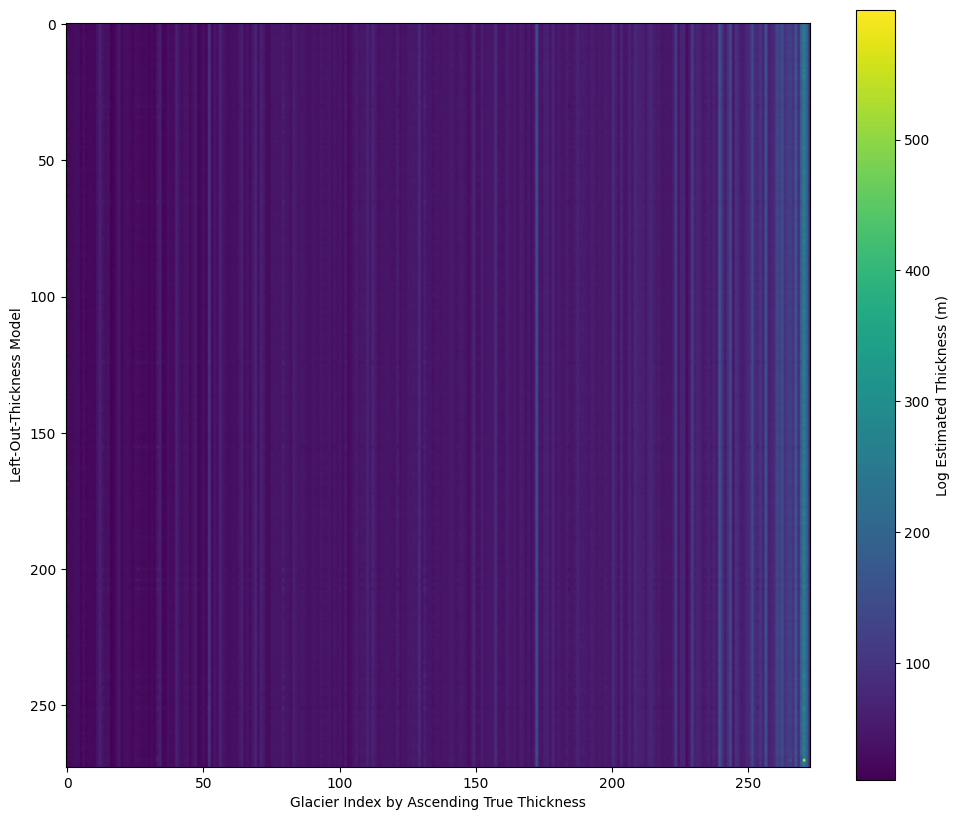

In [5]:
### Visualize the dataset ####

x = (df[cols].T)
plt.figure(figsize = (12,10))
plt.imshow(
    x, cmap = 'viridis',vmin=np.min(x),vmax=np.max(x)
)
plt.colorbar(label = 'Log Estimated Thickness (m)')
plt.xlabel('Glacier Index by Ascending True Thickness')
plt.ylabel('Left-Out-Thickness Model')
# plt.xlabel

Text(0, 0.5, 'Left-Out-Thickness Model')

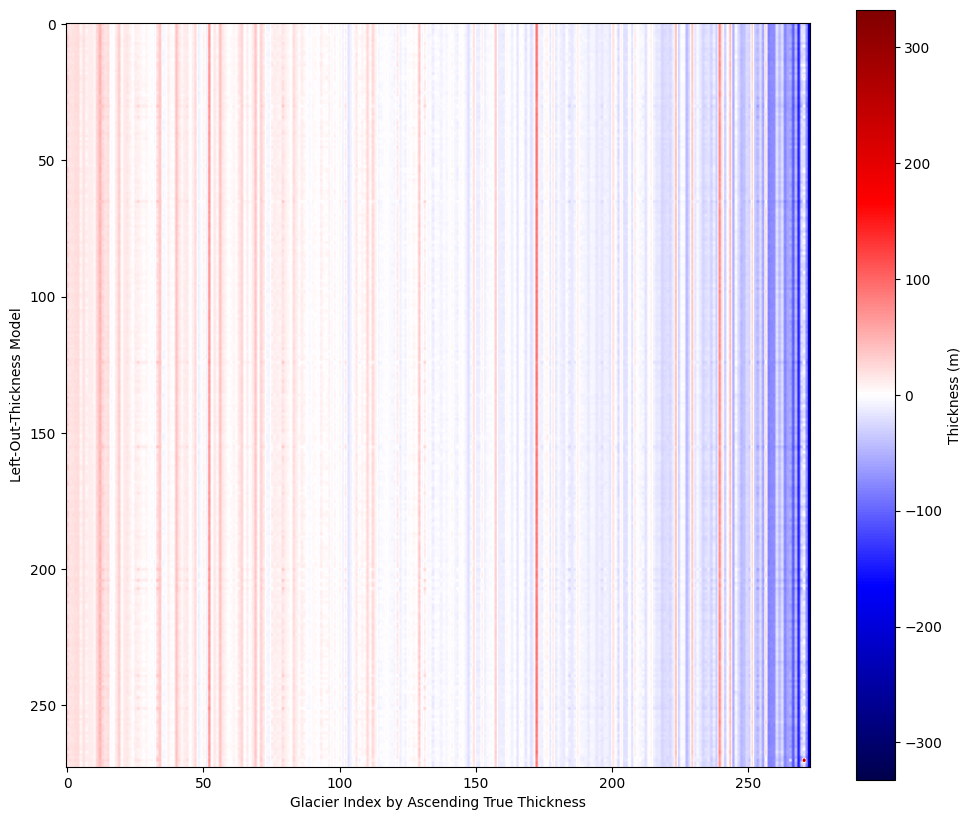

In [6]:
### Visualize the dataset ####
r = (df[cols].T - df['Thickness'])
plt.figure(figsize = (12,10))
plt.imshow(
    r, cmap = 'seismic',vmin=-(np.max(abs(r))),vmax=np.max(abs(r))
)
plt.colorbar(label = 'Thickness (m)')
plt.xlabel('Glacier Index by Ascending True Thickness')
plt.ylabel('Left-Out-Thickness Model')
# plt.xlabel

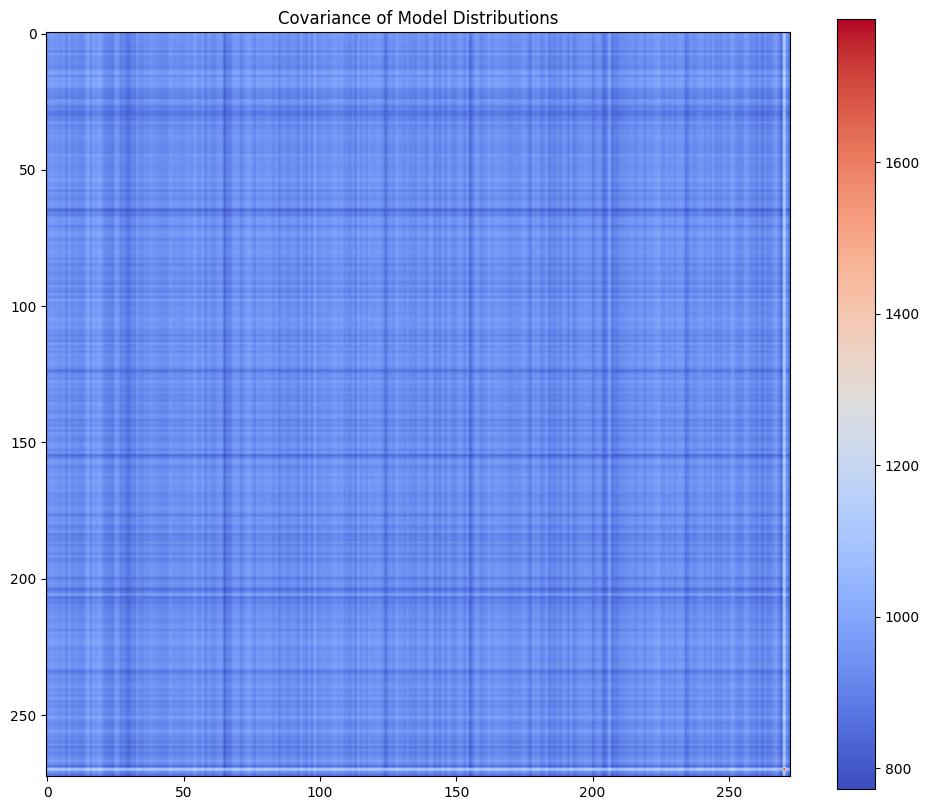

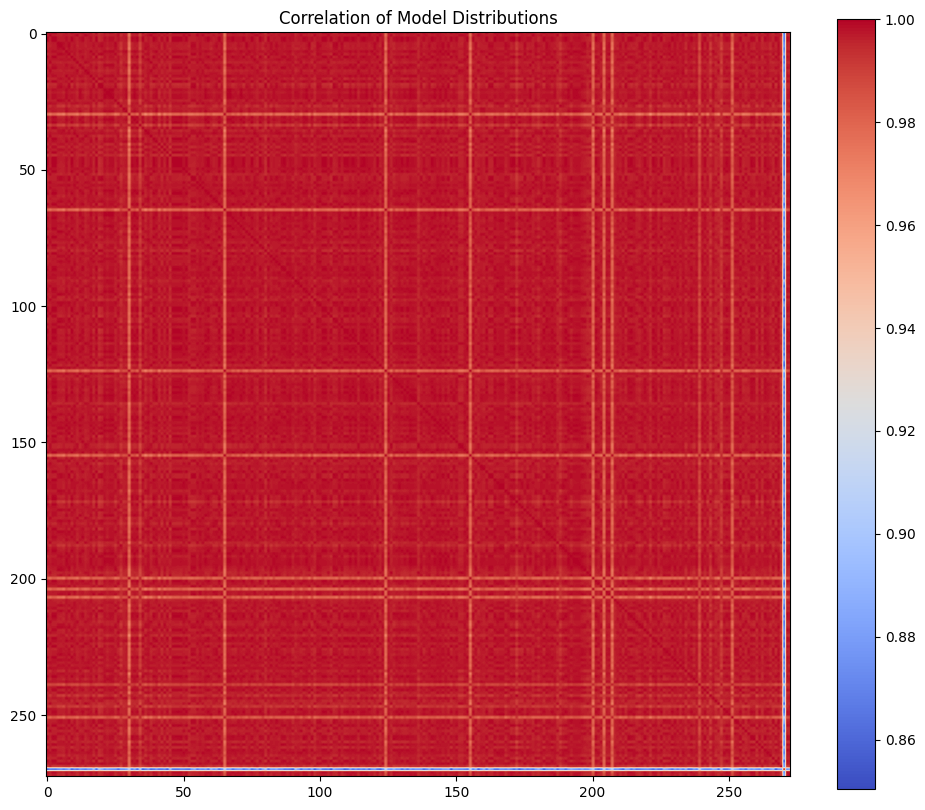

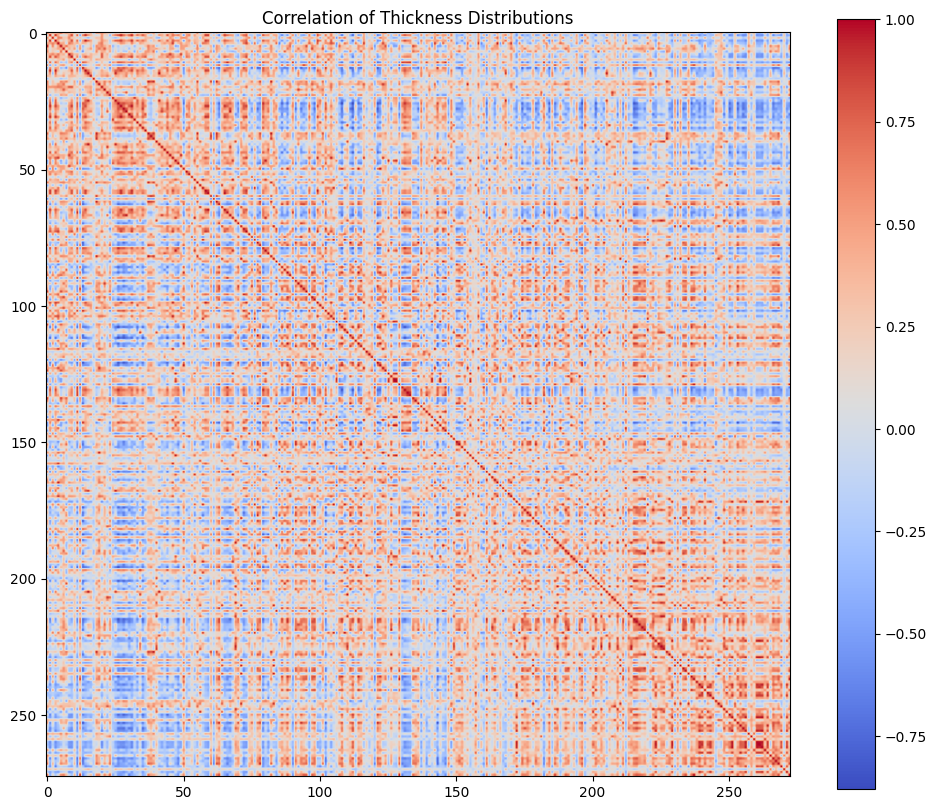

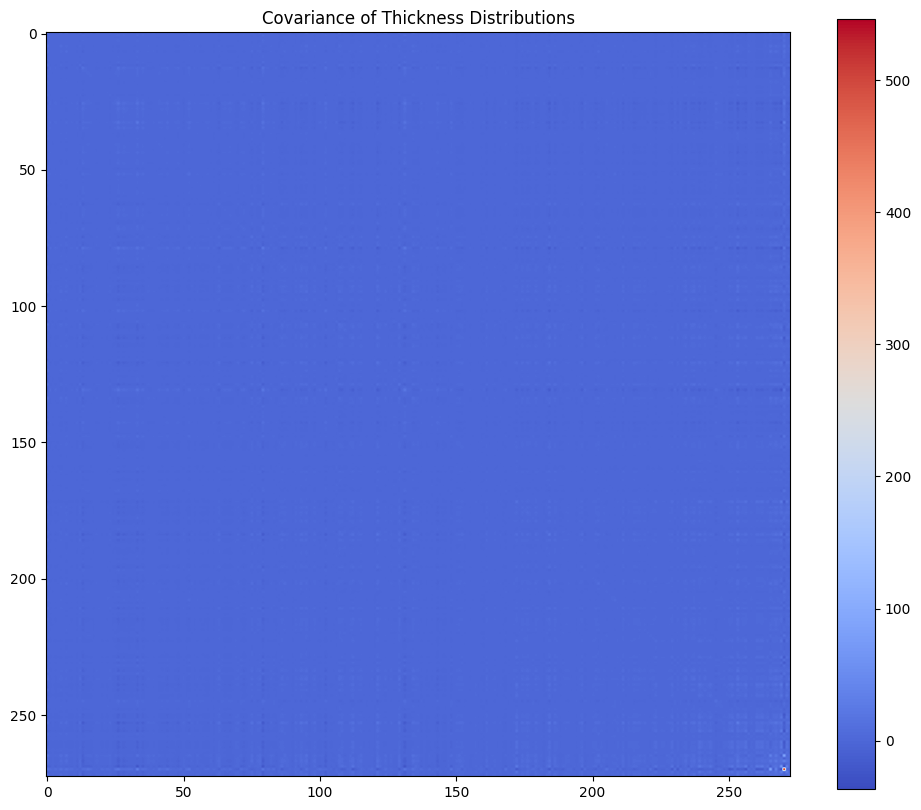

In [7]:
#Each row of m represents a variable
#each column a single observation of all those variables.
#treat each model as a variable
cov1 = np.cov(df[cols].T)
cor1 = np.corrcoef(df[cols].T)

x = cov1

fig = plt.subplots(figsize = (12,10))
plt.imshow(
    x,cmap = 'coolwarm',vmin=np.min(x),vmax=np.max(x)
)
plt.title('Covariance of Model Distributions')
plt.colorbar()

x = cor1

fig = plt.subplots(figsize = (12,10))
plt.imshow(
    x,cmap = 'coolwarm',vmin=np.min(x),vmax=np.max(x)
)
plt.title('Correlation of Model Distributions')
plt.colorbar()

#treat each glacier as a variable
cov2 = np.cov(df[cols])
cor2 = np.corrcoef(df[cols])
x = cor2

plt.figure(figsize=(12, 10))
plt.imshow(
    x, cmap = 'coolwarm',vmin=x.min(),vmax = x.max()
)
plt.title('Correlation of Thickness Distributions')

plt.colorbar()
x = cov2

plt.figure(figsize=(12, 10))
plt.imshow(
    x, cmap = 'coolwarm',vmin=x.min(),vmax = x.max()
)
plt.title('Covariance of Thickness Distributions')

plt.colorbar()

Text(0, 0.5, 'Left-Out-Thickness Model Estimate')

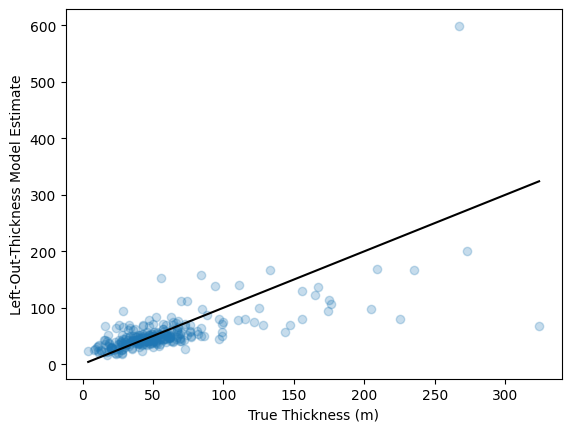

In [8]:
#### Left-Out-Thickness Model Estimates ####
mods = pd.DataFrame(columns = ['LOO','True'])
mods['LOO'] = pd.Series(np.diag(df[cols]))
mods['True'] = (df['Thickness'].reset_index().drop('index', axis = 1))

x = mods['True']
y = mods['LOO']
plt.scatter(
    x,y,alpha = 0.25
)
plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    'k-'
)
plt.xlabel('True Thickness (m)')
plt.ylabel('Left-Out-Thickness Model Estimate')

In [10]:
#### Calculate 95% confidence intervals ####
X = np.mean(df[cols], axis = 1)
se = np.std(df[cols], axis = 1) / np.sqrt(len(cols))

df['LCI'] = X - (1.96 * se)
df['UCI'] = X + (1.96 * se)

lb = df['LCI'] / 1e3 * df['Area'] / 1e3
ub = df['UCI'] / 1e3 * df['Area'] / 1e3

/tmp/ipykernel_2544724/3958088393.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['LCI'] = X - (1.96 * se)
/tmp/ipykernel_2544724/3958088393.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['UCI'] = X + (1.96 * se)


In [11]:
# Calculate 95% confidence intervals ####
X = np.mean(df[cols], axis = 1)
se = np.std(df[cols], axis = 1) / np.sqrt(len(cols))

df['LCI'] = X - (1.96 * se)
df['UCI'] = X + (1.96 * se)

lb = df['LCI'] / 1e3 * df['Area'] / 1e3
ub = df['UCI'] / 1e3 * df['Area'] / 1e3

Text(0.5, 1.0, 'Leave-One-Out X-val 95% CI')

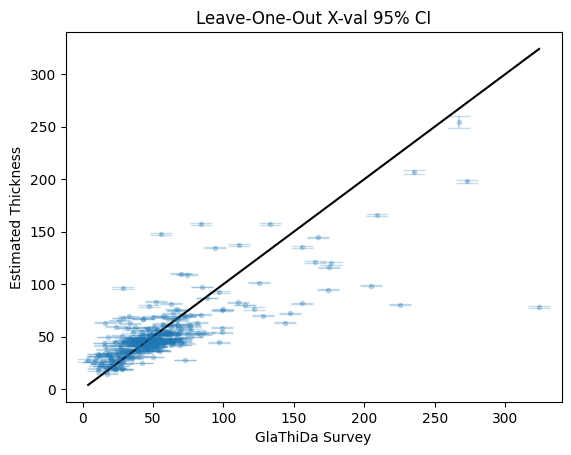

In [14]:
x = df['Thickness']
# y = np.mean(dfci, axis = 1)
# y = df['we']
y = np.mean(df[cols],axis = 1)
plt.errorbar(
    x,y,yerr = df['UCI'] - df['LCI'],
        alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    linestyle = 'None',
    marker = '.',
    capsize = 8,
    color = '#1f77b4',
)

plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)

plt.ylabel('Estimated Thickness')
plt.xlabel('GlaThiDa Survey')
plt.title('Leave-One-Out X-val 95% CI')
# plt.xscale('log')
# plt.yscale('log')

Text(0.5, 1.0, 'Leave-One-Out X-val 95% CI')

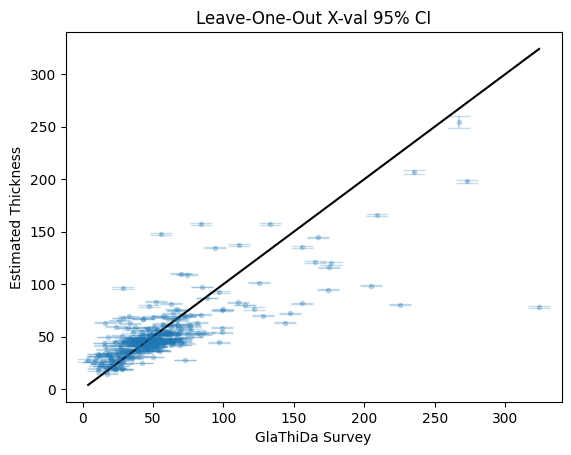

In [15]:
#### Calculate 95% confidence intervals ####
X = np.mean(df[cols], axis = 1)
se = np.std(df[cols], axis = 1) / np.sqrt(len(cols))

df['LCI'] = X - (1.96 * se)
df['UCI'] = X + (1.96 * se)

lb = df['LCI'] / 1e3 * df['Area'] / 1e3
ub = df['UCI'] / 1e3 * df['Area'] / 1e3

x = df['Thickness']
# y = np.mean(dfci, axis = 1)
# y = df['we']
y = np.mean(df[cols],axis = 1)
plt.errorbar(
    x,y,yerr = df['UCI'] - df['LCI'],
        alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    linestyle = 'None',
    marker = '.',
    capsize = 8,
    color = '#1f77b4',
)

plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)

plt.ylabel('Estimated Thickness')
plt.xlabel('GlaThiDa Survey')
plt.title('Leave-One-Out X-val 95% CI')
# plt.xscale('log')
# plt.yscale('log')

Text(0, 0.5, 'Left Out Glacier B Estimates')

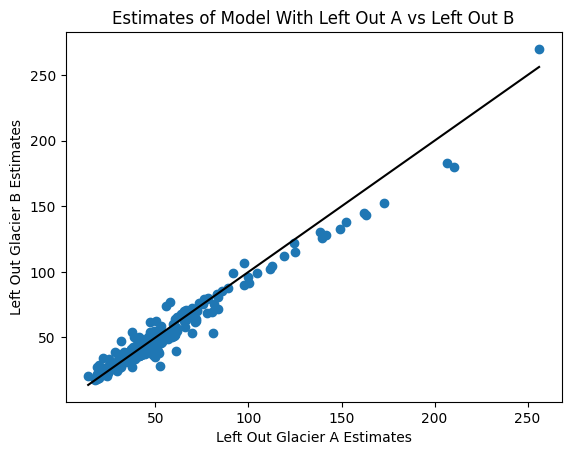

In [16]:
x = df[cols].T.loc[157]
y = df[cols].T.loc[111]
plt.plot(x,y,'o')
plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    'k-'
)
plt.title('Estimates of Model With Left Out A vs Left Out B')
plt.xlabel('Left Out Glacier A Estimates')
plt.ylabel('Left Out Glacier B Estimates')

In [17]:
conditions = [cor2 > 0]
def glac_finder(conditions):

    where = np.where(conditions)
    a = where[1]
    b = where[2]

    t = np.zeros(shape=(len(a), 2))

    combs = [[]]
    for i in tqdm(range(len(a))):
        x = a[i]
        y = b[i]
        if [x,y] in combs:
            continue
        z = np.array([x,y])
        t[i] = z   
        combs.append([y,x])
    t = t[np.where(t[:,0] != t[:,1])]
    return t

def find_diffs(t,obj):
    feat_list = ['Correlation','Distance','Area','Lmax','Slope','Zmin','index1','index2']
    diffs = np.empty(shape = (0,len(feat_list)))
    for i in tqdm(range(len(t))):
        j = int(t[i][0])
        k = int(t[i][1])

        x = df.iloc[j]
        y = df.iloc[k]
        z = np.empty(shape = (len(feat_list),))

        for l,feat in enumerate(feat_list):
            if feat == 'Correlation':
                z[l] = obj[int(t[i][0]),int(t[i][1])]
            if feat == 'Distance':
                z[l] = geopy.distance.geodesic(
                    (x['CenLat'],x['CenLon']),
                    (y['CenLat'],y['CenLon'])
                ).kilometers
            if feat == 'index1':
                z[l] = j
            if feat == 'index2':
                z[l] = k
            if (feat != 'Correlation' and 
                feat != 'Distance' and 
                feat != 'index1' and 
                feat != 'index2'):
                z[l] = abs(x[feat] - y[feat])
        z = np.expand_dims(z,0)
        diffs = np.concatenate((diffs,z),axis = 0)

    diffs = pd.DataFrame(diffs)

    diffs = diffs.rename(columns = {
        0:'Correlation',1:'Distance (km)',2:'Area',
        3:'Lmax',4:'Slope',5:'Zmin',6:'index1',7:'index2'
    })
    diffs = diffs.sort_values('Correlation')
    return diffs

100%|██████████| 544/544 [00:00<00:00, 213103.71it/s]


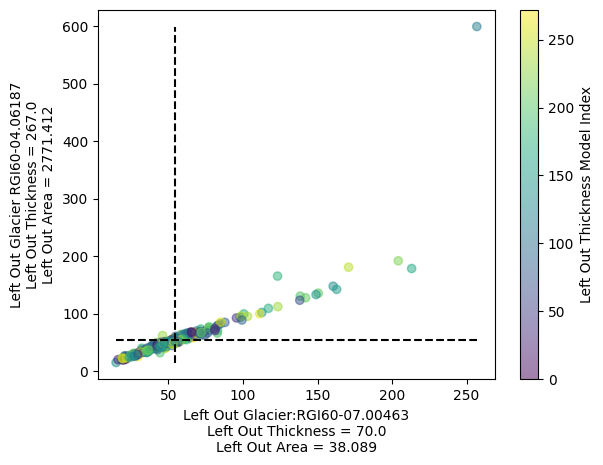

In [24]:
conditions = [cor1 < 0.95]
t = glac_finder(conditions)
i = np.random.randint(0, len(t))

j = int(t[i][0])
k = int(t[i][1])

x = df[cols].T.iloc[j]
y = df[cols].T.iloc[k]
z = df[cols].index
plt.scatter(x,y,c = z,alpha = 0.5)

# model = np.poly1d(np.polyfit(x, y, 1))
# plt.plot(x,model(x),'-r')
plt.xlabel('Left Out Glacier:' + df['RGIId'].iloc[j] + 
          '\nLeft Out Thickness = ' + str(df['Thickness'].iloc[j]) +
          '\nLeft Out Area = ' + str(df['Area'].iloc[j]))
plt.ylabel('Left Out Glacier ' + df['RGIId'].iloc[k] + 
           '\nLeft Out Thickness = ' + str(df['Thickness'].iloc[k]) +
           '\nLeft Out Area = ' + str(df['Area'].iloc[k]))
plt.colorbar(label = 'Left Out Thickness Model Index')
plt.plot(
    (x.mean(),x.mean()),
    (y.min(),y.max()),
    '--k'
)
plt.plot(
    (x.min(),x.max()),
    (y.mean(),y.mean()),
    '--k'
    
)
# plt.axis('square')

100%|██████████| 36856/36856 [00:38<00:00, 963.49it/s] 


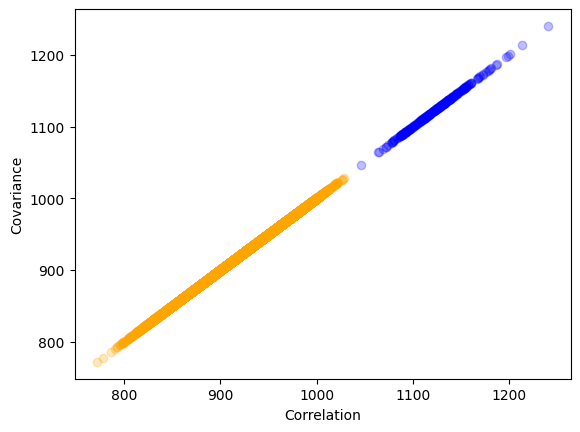

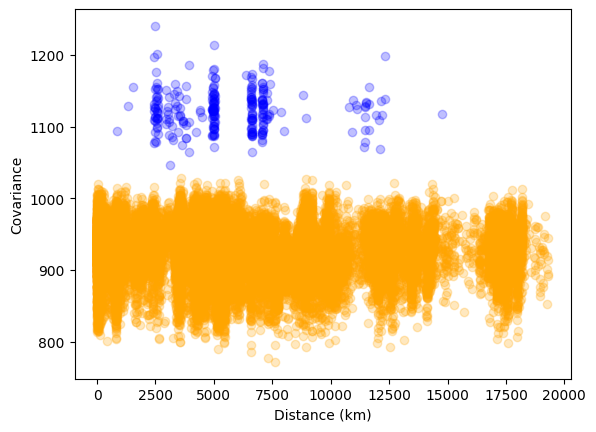

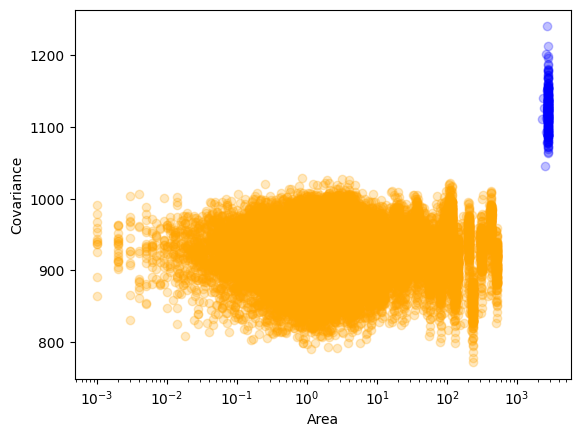

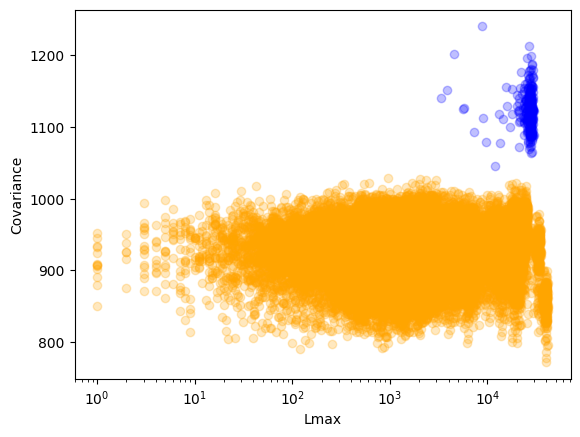

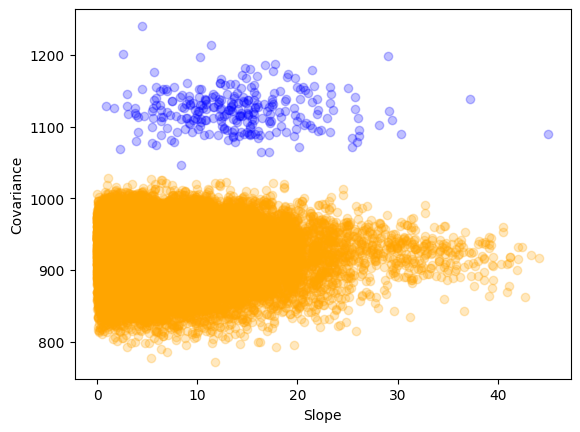

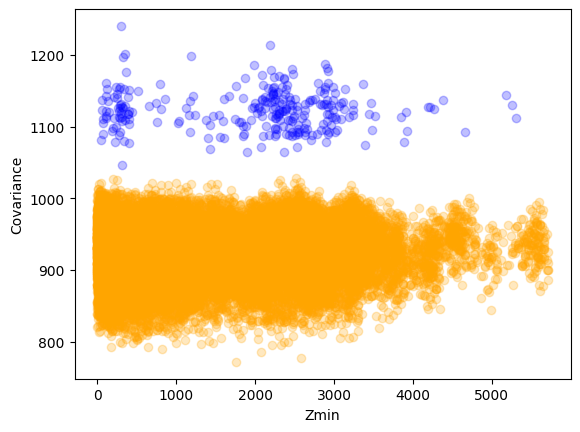

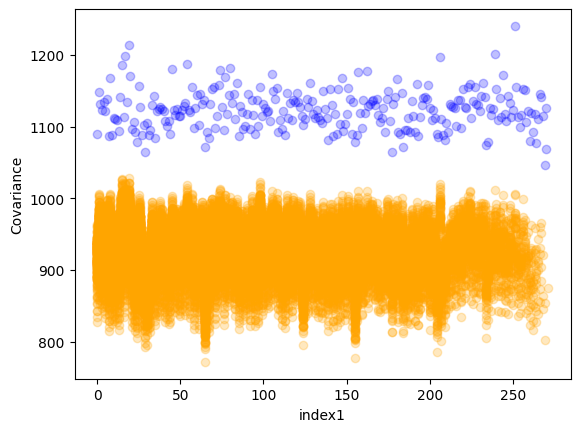

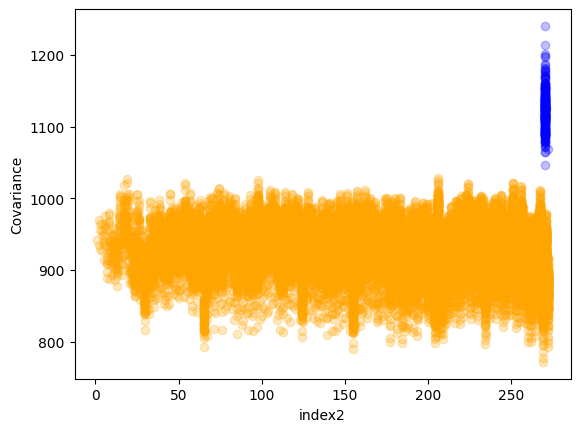

In [25]:
obj = cov1
conditions = [obj > 1045]
t = glac_finder(conditions)
diffs1 = find_diffs(t,obj)

conditions = [obj < 1045]
t = glac_finder(conditions)
diffs2 = find_diffs(t,obj)

feat_list = list(diffs1)

for feat in feat_list:
    plt.scatter(
        diffs1[feat], diffs1['Correlation'], 
        alpha = 0.25,color = 'blue',
        label = 'Corr > 0'
    )
    plt.scatter(
        diffs2[feat],diffs2['Correlation'],
        alpha = 0.25,color = 'orange',
        label = 'Corr < 0'
    )
    if feat == 'Area' or feat == 'Lmax':
        plt.xscale('log')
    plt.xlabel(feat)
    plt.ylabel('Covariance')
    plt.show()

100%|██████████| 272/272 [00:00<00:00, 1182.44it/s]


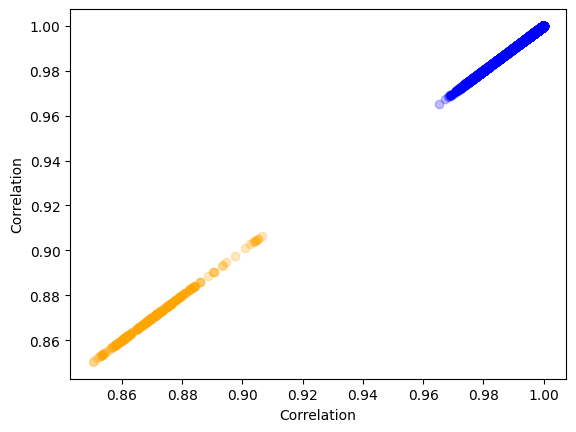

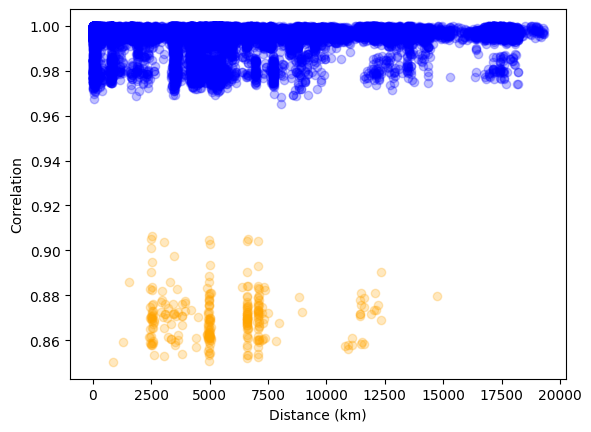

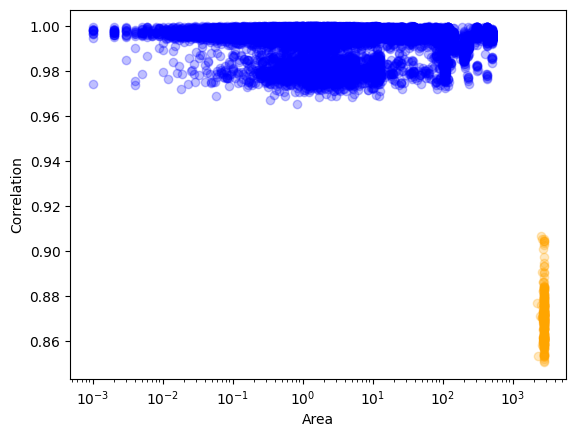

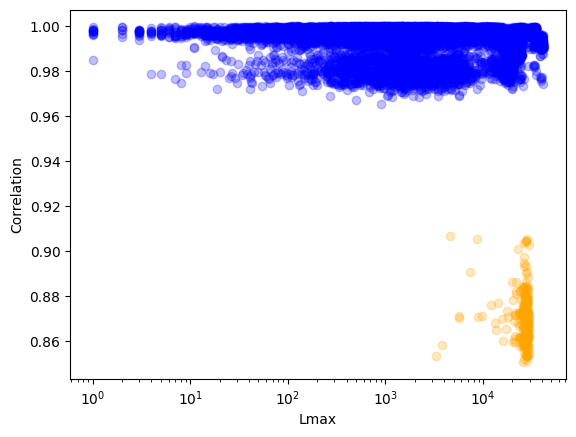

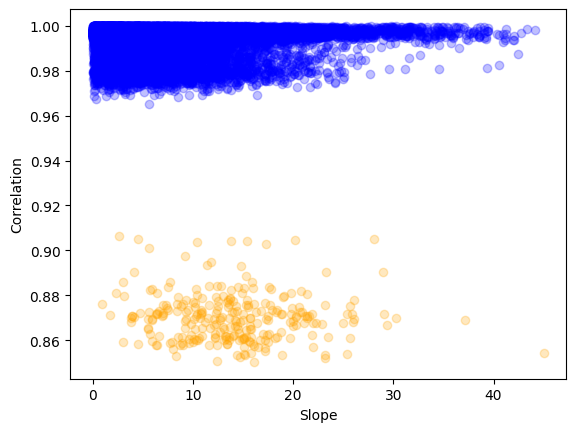

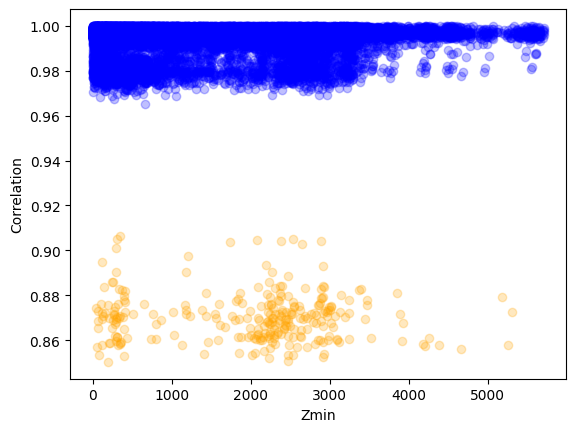

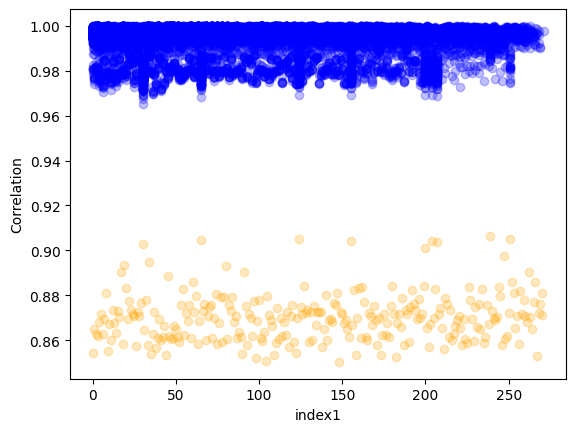

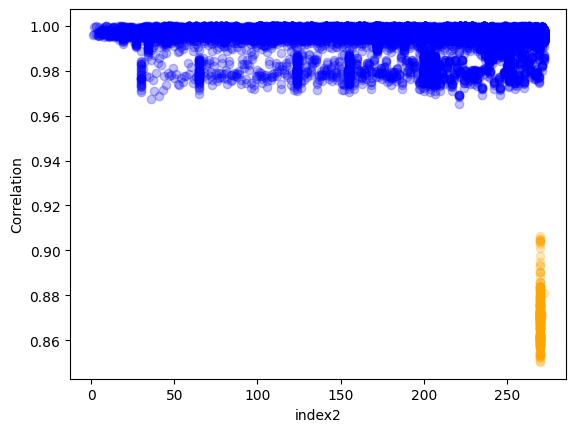

In [26]:
obj = cor1
conditions = [obj > 0.94]
t = glac_finder(conditions)
diffs1 = find_diffs(t,obj)

conditions = [obj < 0.94]
t = glac_finder(conditions)
diffs2 = find_diffs(t,obj)

feat_list = list(diffs1)

for feat in feat_list:
    plt.scatter(
        diffs1[feat], diffs1['Correlation'], 
        alpha = 0.25,color = 'blue',
        label = 'Corr > 0'
    )
    plt.scatter(
        diffs2[feat],diffs2['Correlation'],
        alpha = 0.25,color = 'orange',
        label = 'Corr < 0'
    )
    if feat == 'Area' or feat == 'Lmax':
        plt.xscale('log')
    plt.xlabel(feat)
    plt.ylabel('Correlation')
    plt.show()

In [ ]:
from scipy.sparse.linalg import eigs

In [ ]:
L,Q=eigs(cov2,10)

In [ ]:
Q

In [ ]:
print(L/sum(L))

plt.hist((Q[:,0]),20)
plt.yscale('log')



In [ ]:
sum(np.abs(Q[:,0]) > 0.01)/340

In [ ]:
plt.imshow(cor1,vmin=np.min(cor1),vmax=np.max(cor1),cmap='coolwarm')
plt.xlim([240,273])
plt.ylim([240,273])

In [ ]:
cols[270]

In [ ]:
df.T.loc[115]

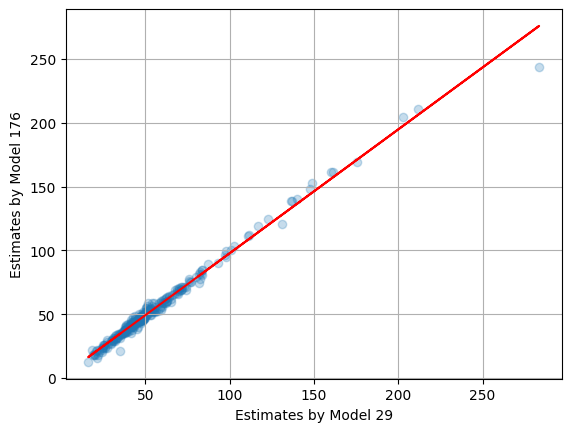

In [27]:
j = np.random.randint(0, 272)
# j = 157
x = df[j]
i = np.random.randint(0, 272)
# i = 57
y = df[i]
plt.scatter(x,y,alpha = 0.25)
# plt.plot(
#     (10,300),
#     (10,300),
#     'k-'
# )

model = np.poly1d(np.polyfit(x, y, 1))


# plt.axis('square')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Estimates by Model ' + str(j))
plt.ylabel('Estimates by Model ' + str(i))
plt.grid()
plt.plot(x,model(x),'-r')
plt.show()

# plt.imshow(cov2,cmap = 'coolwarm',vmin =np.min(cov2), vmax = np.max(cov2))

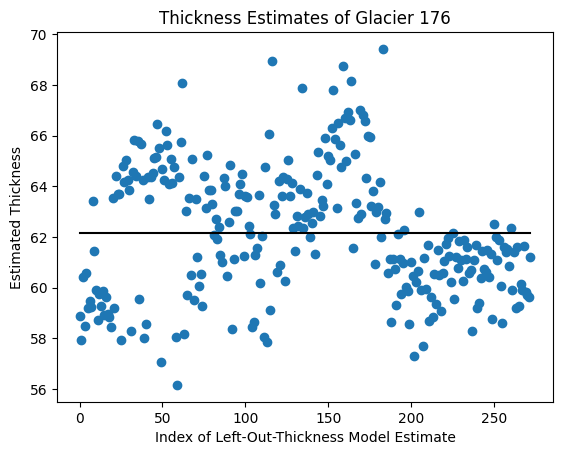

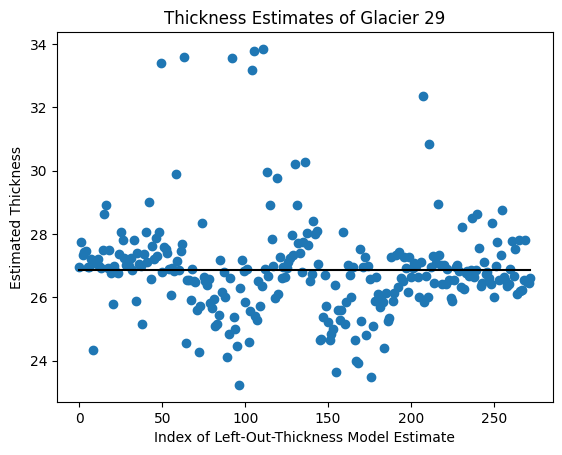

In [28]:
plt.plot((df[cols].iloc[i]),'o')
plt.title('Thickness Estimates of Glacier ' + str(i))
plt.xlabel('Index of Left-Out-Thickness Model Estimate')
plt.ylabel('Estimated Thickness')
plt.plot(
    (0,df.index.sort_values()[-1]),
    (np.mean(df[cols].iloc[i]), np.mean(df[cols].iloc[i])),
    '-k'
)

# plt.plot(
#     (0,340),
#     (df['Thickness'].iloc[i], df['Thickness'].iloc[i]),
#     '-.k'
# )

plt.show()
plt.plot((df[cols].iloc[j]),'o')
plt.title('Thickness Estimates of Glacier ' + str(j))
plt.xlabel('Index of Left-Out-Thickness Model Estimate')
plt.plot(
    (0,df.index.sort_values()[-1]),
    (np.mean(df[cols].iloc[j]), np.mean(df[cols].iloc[j])),
    '-k'
)
# plt.plot(
#     (0,340),
#     (df['Thickness'].iloc[j], df['Thickness'].iloc[j]),
#     '-.k'
# )
plt.ylabel('Estimated Thickness')
plt.show()

In [ ]:
# plt.plot(thickness_estimates[10,:],thickness_estimates[9,:],'o')
# plt.xlabel('Thickness estimates for Glacier A')
# plt.ylabel('Thickness estimates for Glacier B')
# plt.axis('square')

In [ ]:
np.mean(df[cols],axis = 1)

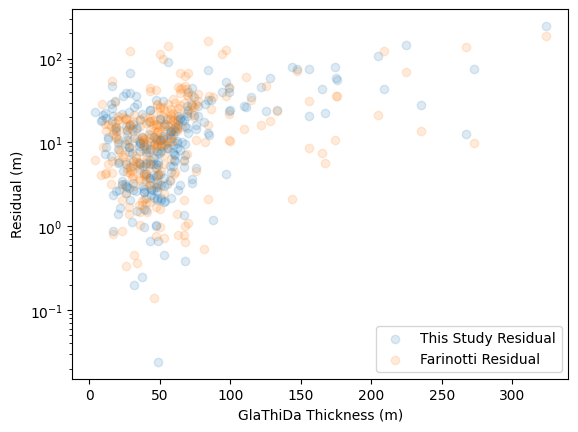

In [62]:
x = df['Thickness']
y = np.mean(df[cols],axis = 1)
z = df['FMT']
plt.scatter(
    x,abs(y-x),alpha = 0.15,label = 'This Study Residual'
)
plt.scatter(
    x,abs(z-x),alpha = 0.15,label = 'Farinotti Residual'
)
plt.plot(
    (x.min(),x.max()),
    (0,0),'k--'
)
plt.xlabel('GlaThiDa Thickness (m)')
plt.ylabel('Residual (m)')
plt.legend()
plt.yscale('log')
# plt.xscale('log')

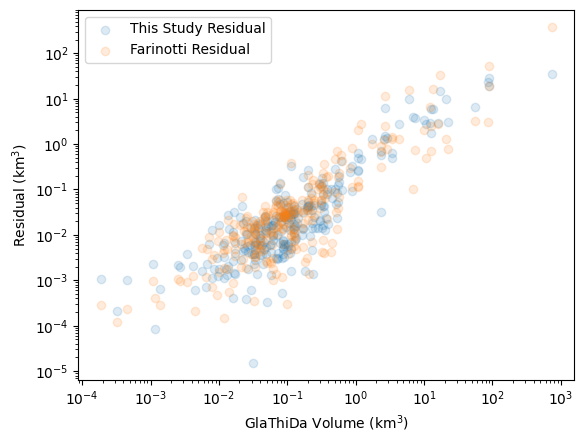

In [61]:
x = (df['Thickness'] / 1e3) * df['Area']
y = (np.mean(df[cols],axis = 1) / 1e3) * df['Area']
z = (df['FMT'] / 1e3) * df['Area']
plt.scatter(
    x,abs(y-x),alpha = 0.15,label = 'This Study Residual'
)
plt.scatter(
    x,abs(z-x),alpha = 0.15,label = 'Farinotti Residual'
)
plt.plot(
    (x.min(),x.max()),
    (0,0),'k--'
)
plt.xlabel('GlaThiDa Volume (km$^3$)')
plt.ylabel('Residual (km$^3$)')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [64]:
np.mean(abs(y-x))

16.481564860640866

In [63]:
np.std(abs(y-x))

23.197642611460633

In [65]:
np.mean(abs(df['FMT']-x))

19.523644747252746

In [66]:
np.std(abs(df['FMT']-x))

26.418622616245226

In [ ]:
df['res'] = y - df['Thickness'] 

df[abs(df['res']) >= 100]

In [ ]:
plt.hist(y-x,bins = 25,log = True)

In [ ]:
plt.scatter(
    df.index, df['res']
)
# plt.xscale('log')

In [ ]:
feat_list = ['CenLat', 'CenLon','Slope','Zmin','Zmed','Zmax','Area','Lmax','Thickness']

for feature in feat_list:
    plt.scatter(
        df.index,
        df[feature]
    )
    plt.xlabel('Index')
    plt.ylabel(feature)
    if feature == 'Area' or feature == 'Lmax':
        plt.yscale('log')
    plt.show()



In [ ]:
cov = pd.DataFrame(cov1)
# cor = pd.DataFrame(cor)

# bad_indexes = cov[cov[cols] == 0].dropna(axis = 0).index
# cov_d = cov.drop(bad_indexes)
# cor_d = cor.drop(bad_indexes)

# cov_d = cov_d.reset_index().drop('index',axis = 1)
# cor_d = cor_d.reset_index().drop('index',axis = 1)

# dftr = dft.drop(bad_indexes)
# dftr = dftr.reset_index().drop('index',axis = 1)

# dfpd = df[cols].T.copy()
# dfpd = dfpd.drop(bad_indexes)
# dfpd = dfpd.reset_index().drop('index', axis = 1)

In [ ]:
# identify columns that have one estimate for all glaciers.
bad_models = df[cols].T[df.T.duplicated()].index
bad_models

In [ ]:
cols = list(filter(lambda a: a not in bad_models.to_list(), cols))
df = df.drop(bad_models)

In [ ]:
n = 0
p = plt.get_cmap('seismic')
for i in tqdm(
    df.index,
):
    x = df[cols].T.loc[i]
    z = normx(x,norm)
    x_eval = np.linspace(z.min(),z.max(),500)

    kde = st.gaussian_kde(np.array(z))
    plt.plot(
        x_eval, kde(x_eval), '-',alpha = 0.15,
        c = p(n/(len(df) - 1))
    )
    n = n + 1
x = df['FMT']
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'orange'
)
plt.grid()

# plt.xscale('symlog')
plt.ylabel('Likelihood')
if norm == True:
    plt.xlabel('Normalized Estimated Thickness')
if norm == False:
    plt.xlabel('Estimated Thickness')
# plt.xscale('log')
# plt.title('Leave-One-Out Thickness PDF  -- sorted by ' + feat + ' ' +  order)
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(
    ax_cb, cmap=p, orientation='vertical',
    ticklocation = 'auto',ticks = [],
    label = 'Left-Out Index'
)
cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
plt.gcf().add_axes(ax_cb)
#     plt.show()


In [ ]:
# check the mean estimate.

x = np.mean(df[cols],axis = 1)
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'blue',label = 'Mean LOO estimate'
)


x = df['Thickness']
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'orange',label = 'GlaThiDa Thickness'
)

# x = df['FMT']
# z = normx(x,norm)
# x_eval = np.linspace(z.min(),z.max(),500)
# kde = st.gaussian_kde(np.array(z))
# plt.plot(
#     x_eval, kde(x_eval), '-',alpha = 1,
#     c = 'red',label = 'Farinotti Thickness'
# )
plt.grid()
plt.legend()
# plt.title('Leave-One-Out Mean Thickness PDF -- sorted by ' + feat + ' ' +  order)

# plt.xscale('symlog')
plt.ylabel('Likelihood')
if norm == True:
    plt.xlabel('Normalized Estimated Thickness')
if norm == False:
    plt.xlabel('Estimated Thickness')
# plt.title('Leave-One-Out Thickness PDF')
# divider = make_axes_locatable(plt.gca())
# ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
# cb1 = mpl.colorbar.ColorbarBase(
#     ax_cb, cmap=p, orientation='vertical',
#     ticklocation = 'auto',ticks = [],
#     label = 'Left-Out Thickness'
# )
# cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
# plt.gcf().add_axes(ax_cb)

#     plt.show()
# plt.xscale('log')

In [ ]:
x = df['Thickness']
y = np.mean(df[cols],axis = 1)
z = df['FMT'] 
plt.scatter(
    x,y,alpha = 0.25,label = 'This Study Volume'
)
plt.scatter(
    x,z,alpha = 0.25,label = 'Farinotti Volume'
)
plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    c = 'orange'    
)
plt.legend()
plt.xlabel('GlaThiDa Volume')
plt.ylabel('Estimated Volume')
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
p = plt.get_cmap('seismic')
n = 0
for i in tqdm(
    df.index,
#     dftr.sort_values('Thickness',ascending = True).reset_index().index
):
#     print(dft['Thickness'].loc[i])

    
    x =cov.loc[i] 
    z = normx(x,norm)

    x_eval = np.linspace(z.min(),z.max(),500)

    kde = st.gaussian_kde(np.array(z))
    plt.plot(
        x_eval, kde(x_eval), '-',alpha = 0.5,
        c = p(n/(len(df)))
    )
    n = n + 1
#     c = p(n/(len(pos) - 1))
# plt.ylim(0,0.2)
# plt.yscale('log')
# plt.xscale('symlog')
plt.ylabel('Density')
if norm == True:
    plt.xlabel('Normalized Covariance')
if norm == False:
    plt.xlabel('Covariance')
# plt.title('Leave-One-Out Covariance PDF -- sorted by ' + feat + ' ' +  order )
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(
    ax_cb, cmap=p, orientation='vertical',
    ticklocation = 'auto',ticks = [],
    label = 'Left-Out Index'
)
cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
plt.gcf().add_axes(ax_cb)

#     plt.show()
